In [1]:
%run 00_analysis_config.ipynb

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


Welcome to JupyROOT 6.24/06

RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [2]:
import visualization, util, event, cutflow, detector
importlib.reload(event)
importlib.reload(visualization)
importlib.reload(util)
importlib.reload(detector)
import visualization as vis
reload(vis)

<module 'visualization' from '/project/def-mdiamond/tomren/jupyter/Mu_helper/muhelper/visualization.py'>

## Basic numbers

In [3]:
DATA_DIR    = "/project/rrg-mdiamond/tomren/mudata/background/"

In [4]:
# Eta range
Eta_min = np.arcsinh(70/(85.47+6)) # Largest angle
Eta_max = np.arcsinh((70+99)/85.47) # Smallest angle
print("Eta min,max:",Eta_min,Eta_max)
print("Set simulation Eta min,max to:",0.65,1.5)

MODULE_Z_RANGE_CMS_cm = [70_00, 70_00+90_00]
MODULE_Y_RANGE_CMS_cm = [85_47, 85_47+11_00]

Eta min,max: 0.7053249760455805 1.433438284682681
Set simulation Eta min,max to: 0.65 1.5


In [13]:
# Check MATHUSLA geometric acceptance with pythia
# pythia_w_to_muon.mac
filename = f"../tracker_6layers/scripts/data/20231122/185739/run0.root"

tfile = root.TFile.Open(filename)
tree_name = tfile.GetListOfKeys()[0].GetName()
Tree = tfile.Get(tree_name)

barnches = Tree.GetListOfBranches()
nevents = int(Tree.GetEntries())
branch_list = [barnches[i].GetName() for i in range(len(barnches))]
print(nevents)
print("10000 simulated")

93
10000 simulated


In [18]:
# Estimation of computing resources for muon background 
muons_per_minute = 200   # per minute, at pT=40 GeV
muon_storage     = 1.3e3 # [Bytes] per simulated muon, not recorded muon. 52MB per 40 k simulated muons at pT=35 GeV.
N_muons_at_CMS = 11e10
CMS_muon_veto = 0.1
MATHUSLA_acceptance = 0.01
N_muons_to_simulate = N_muons_at_CMS*CMS_muon_veto*MATHUSLA_acceptance

total_time_in_CPUyear = N_muons_to_simulate/muons_per_minute/(365*24*60)
total_storage_in_GB   = N_muons_to_simulate*muon_storage/1e9
print("Muons to simulate:", N_muons_to_simulate)
print("CPU-year", total_time_in_CPUyear)
print("Storage [GB]", total_storage_in_GB)

Muons to simulate: 110000000.0
CPU-year 1.0464231354642313
Storage [GB] 143.0


In [5]:
Pt_list    = [8,12,20,30,35,40] # GeV/c
EventCount = 40000

filenames = []
for pT in Pt_list:
    files = glob.glob(f"{DATA_DIR}/test/muon_cms__Pt_{pT}_GeV/*/*/stat_v1.root")
    if len(files)==0:
        print("No file for pT", pT)
    elif len(files)>1:
        print("More than one file found for pT", pT)
    else:
        filenames.append(files[0])
         
Pt_list_new = Pt_list[3:]            
            
#------- Example code for open one file-----------
# filename = f"{DATA_DIR}/test/muon_cms__Pt_30_GeV//20231107/183808//run0.root"
# tfile = root.TFile.Open(filename)
# tree_name = tfile.GetListOfKeys()[0].GetName()
# Tree = tfile.Get(tree_name)

# barnches = Tree.GetListOfBranches()
# nevents = int(Tree.GetEntries())
# branch_list = [barnches[i].GetName() for i in range(len(barnches))]
# print(branch_list)

No file for pT 8
No file for pT 12
No file for pT 20


In [30]:
def process_file(filename):
    tfile = root.TFile.Open(filename)
    tree_name = tfile.GetListOfKeys()[0].GetName()
    Tree = tfile.Get(tree_name)
    
    # Try if the tree is empty
    try:
        branches = Tree.GetListOfBranches()
    except:
        data={}
        data["etas"]=np.array([])
        data["phis"]=np.array([])
        data["nhits"]=np.array([])  
        return data
        
    nevents = int(Tree.GetEntries())
    branch_list = [branches[i].GetName() for i in range(len(branches))]

    
    
    
    # things to get from this file
    etas = []
    phis = []
    nhits = []
    
    for entry in tqdm(range(nevents)):
        Tree.GetEntry(entry)
        px = Tree.GenParticle_py[0]
        py = -Tree.GenParticle_pz[0]
        pz = Tree.GenParticle_px[0]
        pT = np.linalg.norm([px,py])
        
        eta=np.arcsinh(pz/pT)
        phi=np.arccos(px/pT)
        
        hits_y = np.array(util.c2list(Tree.Digi_y))
        hits_z = np.array(util.c2list(Tree.Digi_z))
        mask_non_fw = (hits_z>=MODULE_Z_RANGE_CMS_cm[0]) & (hits_y>=MODULE_Y_RANGE_CMS_cm[0])
        nhit = sum(np.array(util.c2list(Tree.Digi_track_id))[mask_non_fw]==1)
        
        
        etas.append(eta)
        phis.append(phi)
        nhits.append(nhit)
        
    data={}
    data["etas"]=np.array(etas)
    data["phis"]=np.array(phis)
    data["nhits"]=np.array(nhits)
    
    return data


Data = []
for fn in filenames:
    Data.append(process_file(fn))

100%|██████████| 23202/23202 [00:08<00:00, 2870.96it/s]


In [31]:
for ipT, pT in enumerate(Pt_list_new):
    print(pT,sum(Data[ipT]["nhits"]>=4),len(Data[ipT]["nhits"]>=4))

30 1406 2813
35 9027 14283
40 13457 23202


---

In [6]:
filename = f"{DATA_DIR}/test/muon_cms__Pt_35_GeV//20231107/183808//stat_v1.root"

tfile = root.TFile.Open(filename)
tree_name = tfile.GetListOfKeys()[0].GetName()
Tree = tfile.Get(tree_name)

barnches = Tree.GetListOfBranches()
nevents = int(Tree.GetEntries())
branch_list = [barnches[i].GetName() for i in range(len(barnches))]
print(branch_list)

['NumHits', 'Hit_energy', 'Hit_time', 'Hit_detId', 'Hit_particlePdgId', 'Hit_G4TrackId', 'Hit_G4ParentTrackId', 'Hit_x', 'Hit_y', 'Hit_z', 'Hit_particleEnergy', 'Hit_particlePx', 'Hit_particlePy', 'Hit_particlePz', 'Digi_numHits', 'Digi_time', 'Digi_x', 'Digi_y', 'Digi_z', 'Digi_energy', 'Digi_px', 'Digi_py', 'Digi_pz', 'Digi_particle_energy', 'Digi_pdg_id', 'Digi_track_id', 'Digi_layer_id', 'Digi_seed', 'GenParticle_index', 'GenParticle_G4index', 'GenParticle_pdgid', 'GenParticle_time', 'GenParticle_x', 'GenParticle_y', 'GenParticle_z', 'GenParticle_energy', 'GenParticle_px', 'GenParticle_py', 'GenParticle_pz', 'GenParticle_mass', 'EXTRA_12', 'EXTRA_13', 'EXTRA_14', 'EXTRA_15', 'Vertex_k_m_t', 'Vertex_k_m_x', 'Vertex_k_m_y', 'Vertex_k_m_z', 'Vertex_k_m_cov_t_x', 'Vertex_k_m_cov_t_y', 'Vertex_k_m_cov_t_z', 'Vertex_k_m_cov_x_y', 'Vertex_k_m_cov_x_z', 'Vertex_k_m_cov_y_z', 'Vertex_k_m_ErrorT', 'Vertex_k_m_ErrorX', 'Vertex_k_m_ErrorY', 'Vertex_k_m_ErrorZ', 'Vertex_k_m_chi2', 'Vertex_k_m_c

In [6]:
Tree.GetEntry(1)
print(Tree.Digi_track_id)

{ 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5184, 18564, 26330 }


In [7]:
hitn = []
for entry in tqdm(range(nevents)):
    Tree.GetEntry(entry)
    
    hitn.append(Tree.Hit_x.size())

100%|██████████| 14283/14283 [00:02<00:00, 5333.94it/s]


findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.


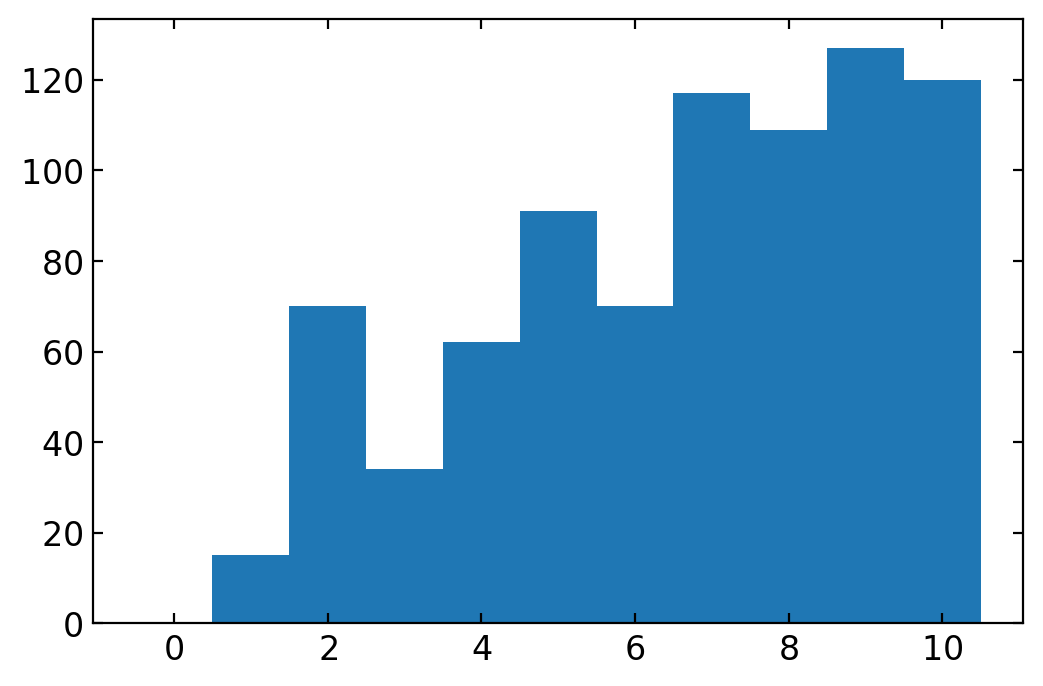

In [8]:
hist(hitn, bins=np.linspace(-0.5,10.5,12));

In [30]:
theta_all = []
pt_all = []
pt_calc = []
for entry in tqdm(range(nevents)):
    Tree.GetEntry(entry)
    
    if Tree.Hit_x.size()>1:
        # x = Tree.Hit_x[0]
        # y = Tree.Hit_y[0]    
        # z = Tree.Hit_z[0]
        px = Tree.GenParticle_py[0]
        py = -Tree.GenParticle_pz[0]
        pz = Tree.GenParticle_px[0]
        

        dx = Tree.Hit_x[1]-Tree.Hit_x[0]
        dy = Tree.Hit_y[1]-Tree.Hit_y[0]    
        dz = Tree.Hit_z[1]-Tree.Hit_z[0]    

        # e_ip = [x,y,z]/np.linalg.norm([x,y,z])
        e_ip = [px,py,pz]/np.linalg.norm([px,py,pz])
        e_muon = [dx,dy,dz]/np.linalg.norm([dx,dy,dz])
        theta = np.arccos(np.dot(e_ip, e_muon))
        theta_all.append(theta)
        pt_all.append(Tree.GenParticle_pt[0])
        pt_calc.append(np.linalg.norm([py,px]))
theta_all=np.array(theta_all)        

100%|██████████| 14283/14283 [00:02<00:00, 6827.91it/s]


Text(0.5, 0, 'pT [MeV]')

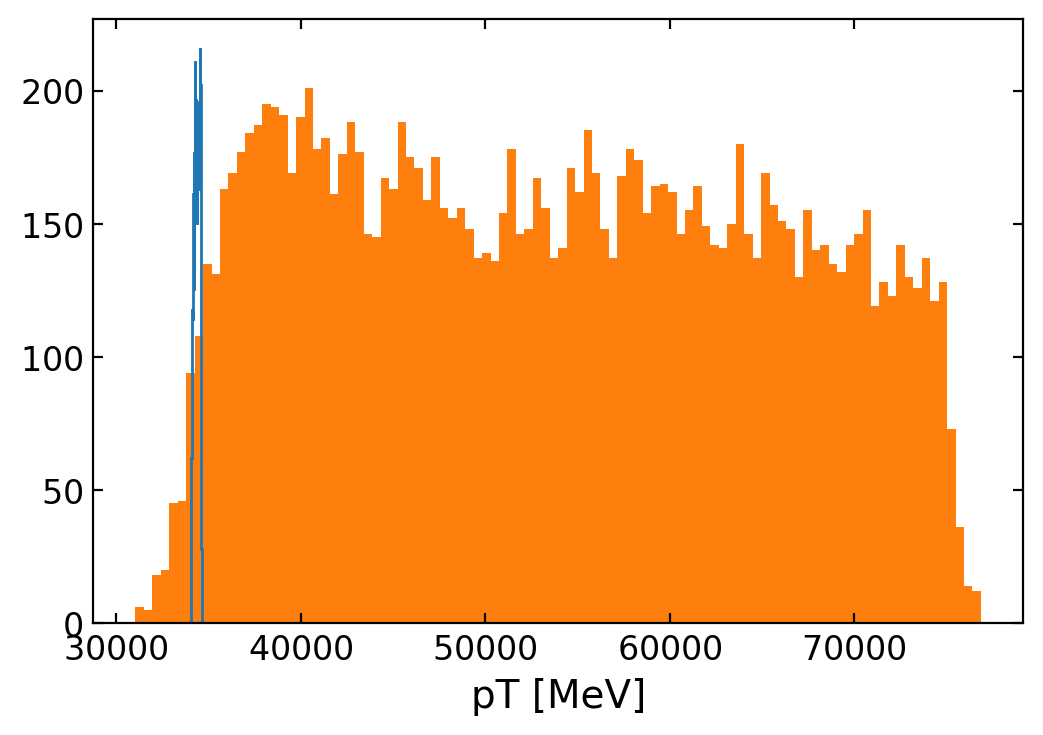

In [31]:
hist(pt_calc,histtype="step");
hist(pt_all);
xlabel("pT [MeV]")

In [36]:
sum(theta_all/2/np.pi*360>25)/14000

0.019071428571428573

Text(0.5, 0, 'Deflection angle [degree]')

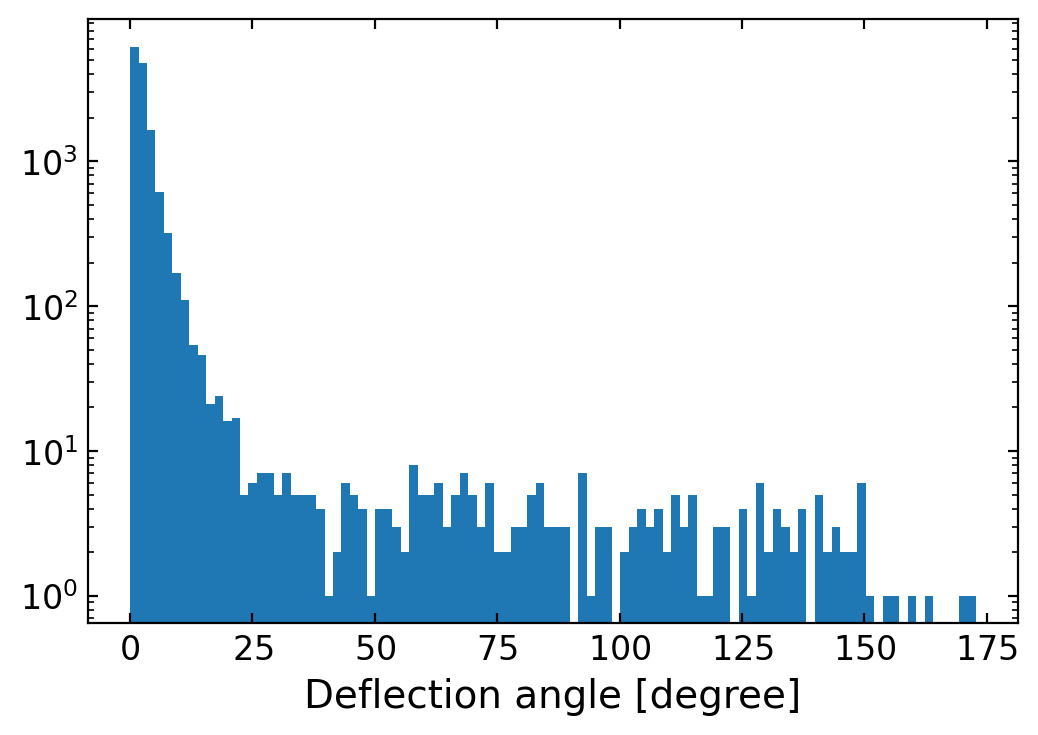

In [37]:
hist(theta_all/2/np.pi*360,bins=100,log=1);
xlabel("Deflection angle [degree]")

---
# Pythia dev

In [5]:
def parse_hepmc(filename):
    particles = []
    with open(filename) as f:
        while True:
        # for i in tqdm(range(100_00)):
            line = f.readline()
            if not line:
                break    
            line = line.split(" ")

            if (line[0]=="P") and (line[8]=="1"):
                if ((line[2]=="13")|(line[2]=="-13")) :
                    particles.append([float(line[3]), float(line[4]), float(line[5]), float(line[6]), int(line[2])])
        
    # print("finished")
    return particles
    
# import pyhepmc
# N_PRINT = 1000

# particles = []
# with pyhepmc.open("scripts/proc_sm_muprod_matched/Events/run_01/tag_2_pythia8_events.hepmc") as f:
#     # while True:
#     for i in tqdm(range(100_00)):
#         event = f.read()
#         if not event:
#             break
#         for p in event.particles:
#             # if len(p.children)==0:
#             #     print(p.status)
#             # Status=1 means "Undecayed physical particle"
#             if (p.status==1) and (p.pid in [13, -13]):
#                 # print(p)
#                 particles.append([p.momentum.px,p.momentum.py,p.momentum.pz,p.momentum.e, p.pid])

            

In [6]:
filename = "scripts/proc_sm_muprod_matched/Events/run_01/tag_2_pythia8_events.hepmc"

# /project/rrg-mdiamond/tomren/mudata/background/proc_sm_muprod_matched_filereader/
particles = np.array(parse_hepmc(filename))

In [8]:
pt = np.linalg.norm(particles[:,:2],axis=1)
pl = particles[:,2]
px = particles[:,0]
py = particles[:,1]
p = np.linalg.norm(particles[:,:3],axis=1)
eta = np.arctanh(pl/p)
phi = np.arctan(px/py)

In [10]:
filename_comp = "scripts/proc_sm_muprod_matched/Events/run_02/tag_3_pythia8_events.hepmc"

# /project/rrg-mdiamond/tomren/mudata/background/proc_sm_muprod_matched_filereader/
particles_comp = np.array(parse_hepmc(filename_comp))
pt_comp = np.linalg.norm(particles_comp[:,:2],axis=1)

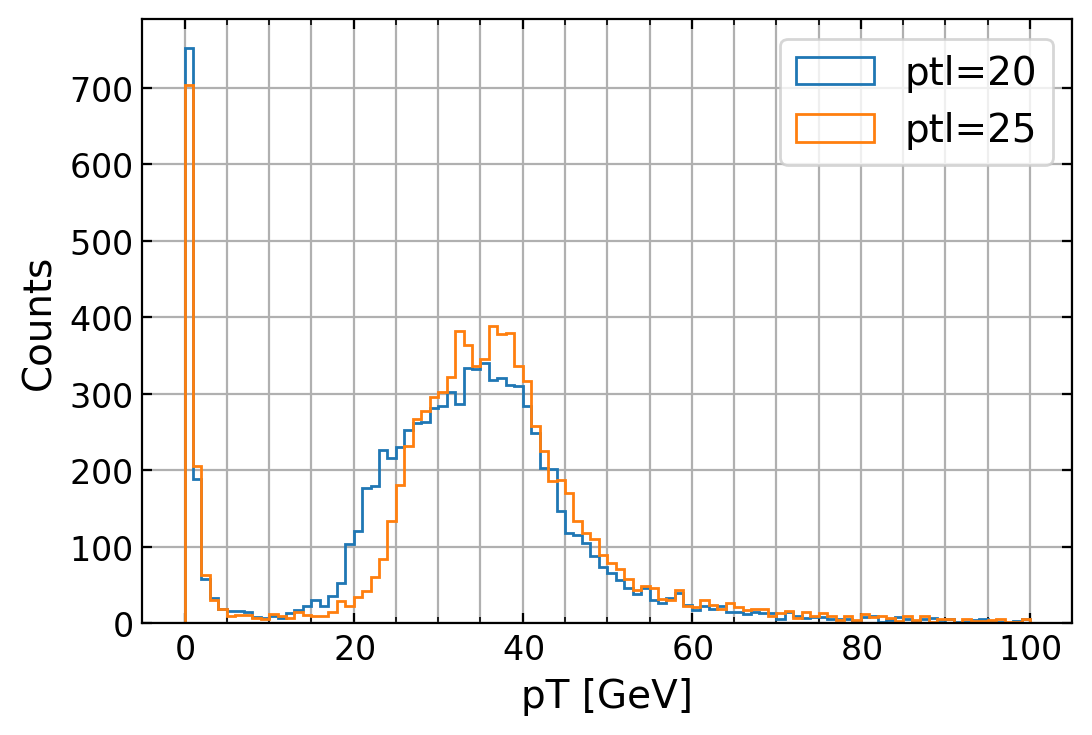

In [17]:
hist(pt,range=(0,100), histtype="step",label="ptl=20");
hist(pt_comp,range=(0,100), histtype="step",label="ptl=25");


gca().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

xlabel("pT [GeV]")
ylabel("Counts")
legend()
grid(which="both")
show()

In [9]:
sum((pt>30))/len(pt)

0.6023001095290252

In [14]:
sum((pt>30) & (eta>0.65) & (eta<1.5) & sum(abs(phi)<0.8))/len(pt)/2

0.06610076670317634

Text(0, 0.5, 'eta')

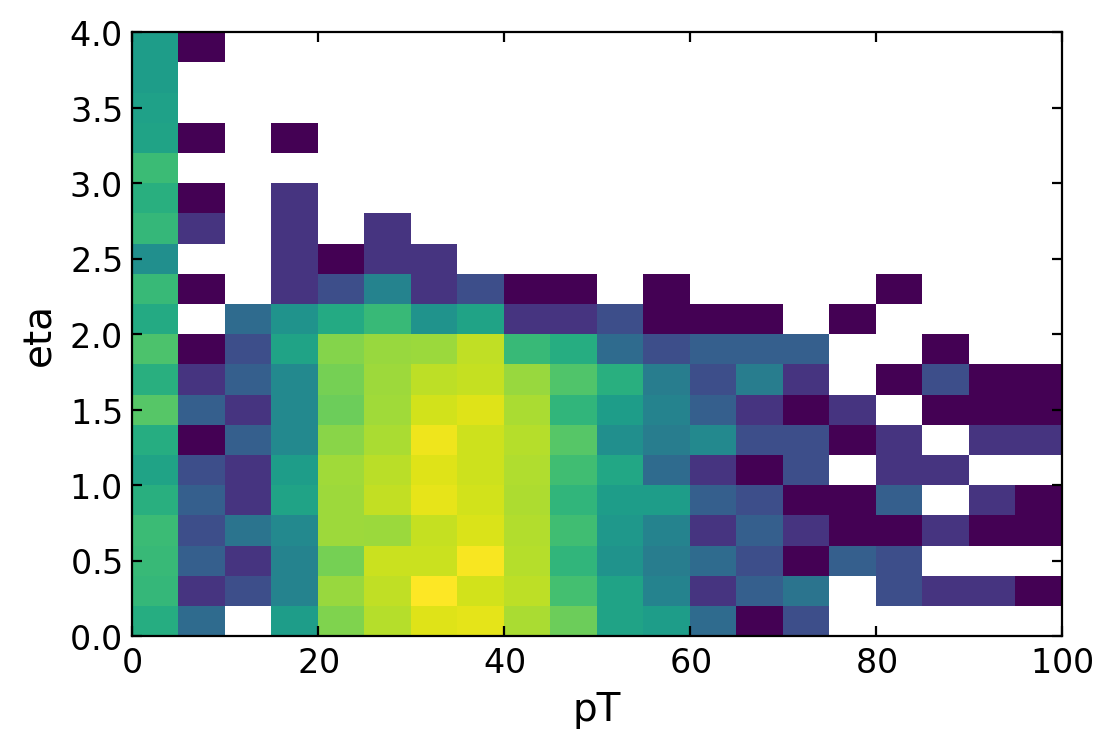

In [17]:
hist2d(pt,eta, range=((0,100),(0,4)),norm=LogNorm(),bins=(20,20));
xlabel("pT")
ylabel("eta")

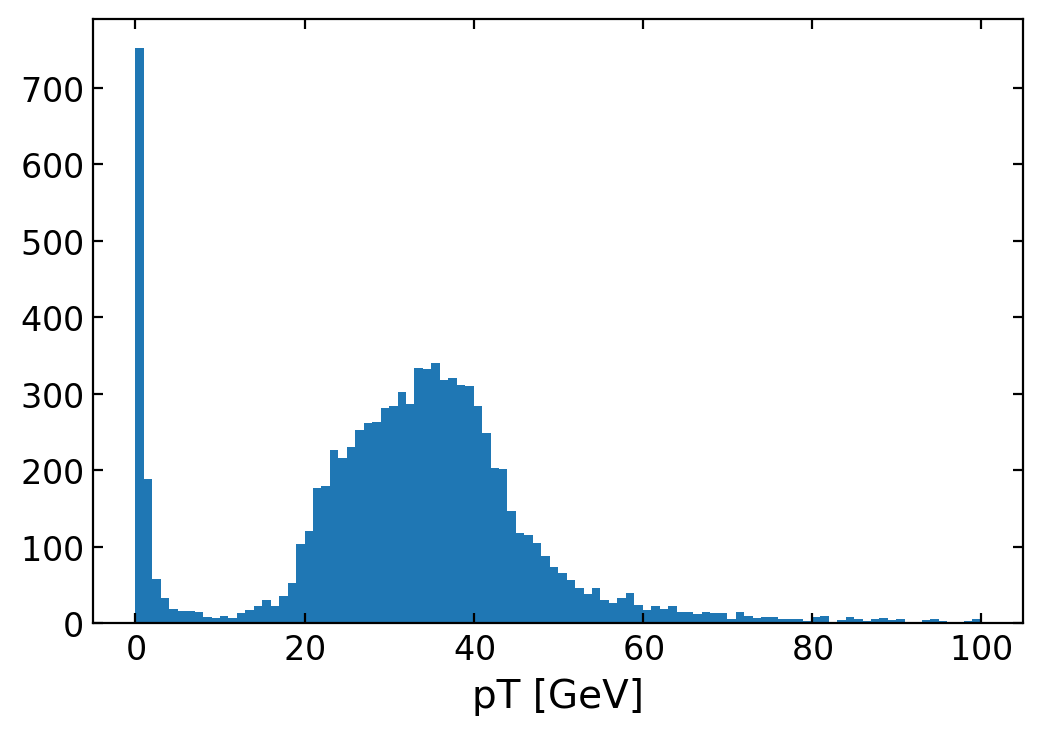

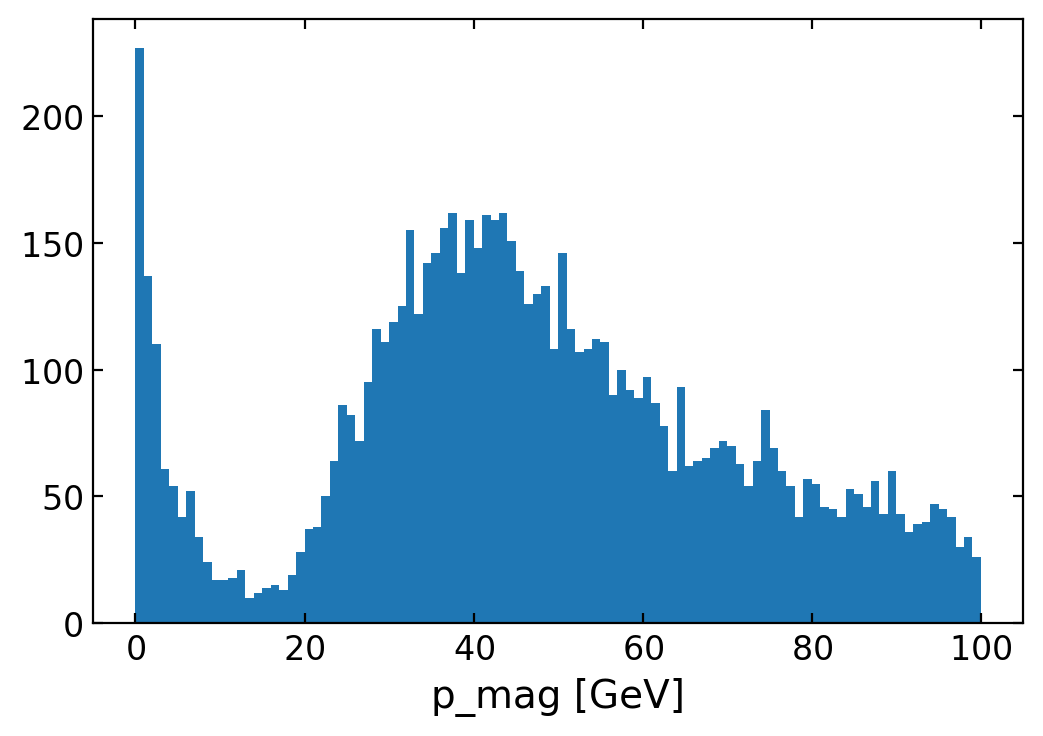

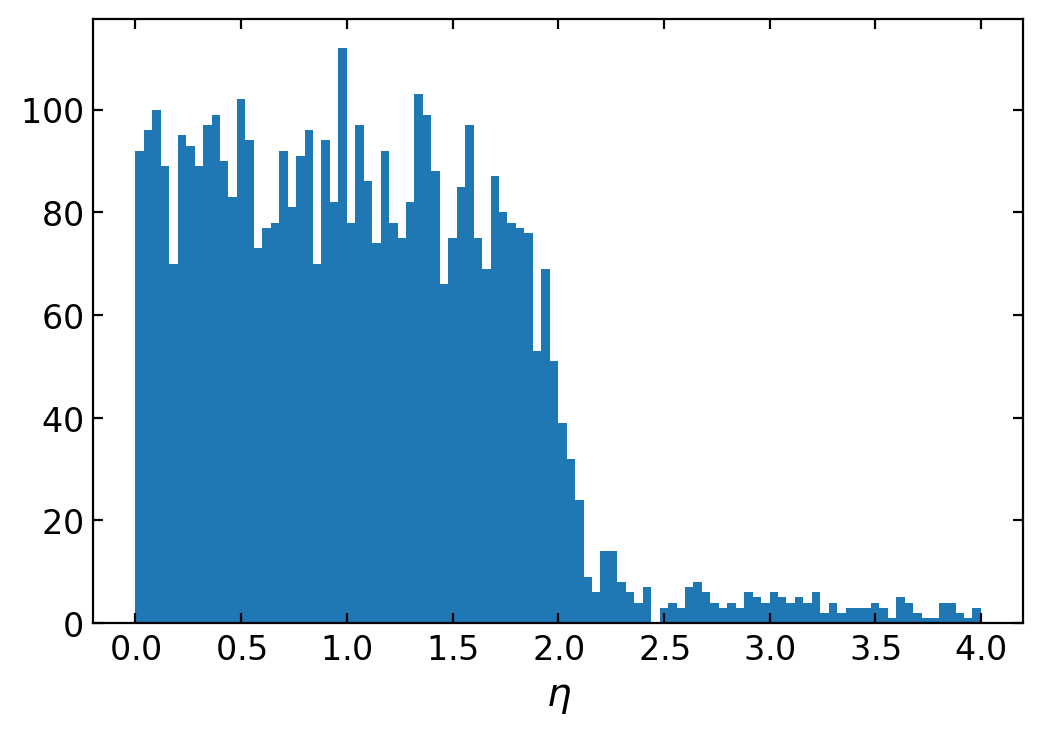

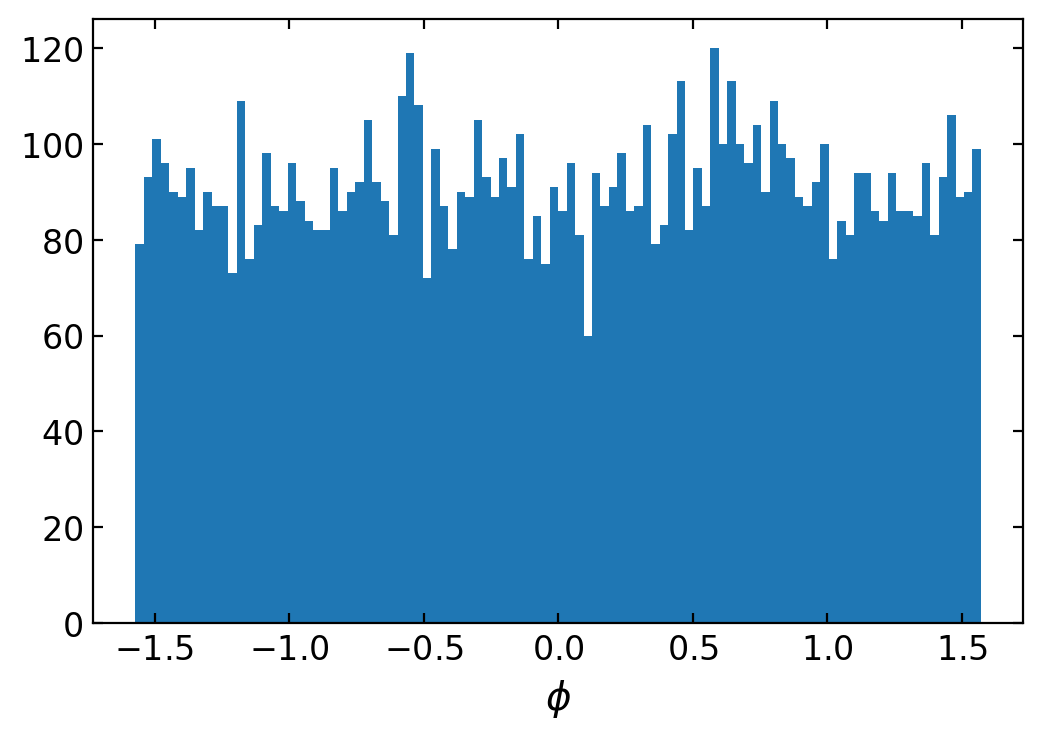

In [24]:
hist(pt,range=(0,100));
xlabel("pT [GeV]")
show()

hist(p,range=(0,100));
xlabel("p_mag [GeV]")
show()

hist(eta,range=(0,4));
xlabel("$\eta$")
show()

hist(phi,range=(-0.5*pi,0.5*np.pi));
xlabel("$\phi$")
show()